<a href="https://colab.research.google.com/github/mateusokp/Deep-Learning/blob/main/E06_Algoritmo_Gen%C3%A9tico_Cart_Pole.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title
%%capture
!pip install gym pyvirtualdisplay
!apt-get install -y xvfb python-opengl ffmpeg
!apt-get install build-essential python-dev swig python-pygame
!apt-get update
!apt-get install cmake
!pip install --upgrade setuptools
!pip install ez_setup
!pip install gym
!pip install box2d-py

import gym
from gym.wrappers import Monitor
import glob
import io
import base64
from IPython.display import HTML, clear_output, YouTubeVideo
from pyvirtualdisplay import Display
from IPython import display as ipythondisplay

display = Display(visible=0, size=(1400, 900))
display.start()

"""
Utility functions to enable video recording of gym environment 
and displaying it.
To enable video, just do "env = wrap_env(env)""
"""

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")
    

def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env

# E06 Algoritmo Genético Cart-Pole

Neste exercício você vai usar o que aprendeu sobre algoritmos genéticos e neuro-evolução para implementar um algoritmo genético capaz de evoluir os parâmetros de uma rede neural que deverá controlar um sistema de pêndulo invertido.

Em inglês conhecido como _cart-pole_, o pêndulo invertido é um problema clássico muito usado para fins didáticos, principalmente em disciplinas ligadas à modelagem e controle de sistemas dinâmicos em engenharia.

Para entender melhor o problema, veja o vídeo abaixo, onde um aluno de graduação apresenta seu projeto de TCC:

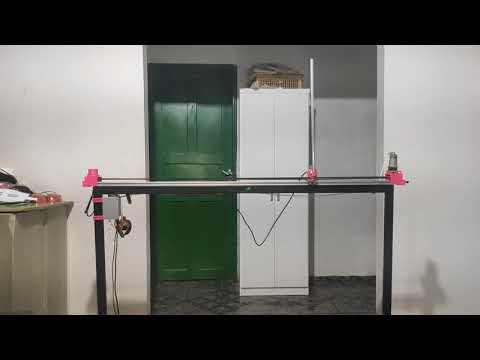

In [ ]:
YouTubeVideo('Pf79Z32B5Kk')

## Introdução

Neste trabalho, você tomará como ponto de partida o [código disponível neste link aqui](https://colab.research.google.com/drive/1X68CYfPYcKN7qvPfOlkgGURP6E0PLE5X?usp=sharing). De forma muito semelhante ao código do link acima, aqui também utilizaremos um ambiente do OpenAI Gym - só que desta vez, ao invés de tentarmos aterrizar foquetes, tentaremos equilibrar o pêndulo.

Veja o exemplo de código abaixo:

In [ ]:
# Aqui importamos o NumPy para
# gerar as ações aleatórias
# que precisaremos mais abaixo

import numpy as np

# Esta linha de código cria o ambiente
# usando o OpenAI Gym. Note que o comando
# está usando a função wrap_env() que serve
# para capturar as imagens e gerar um vídeo
# que permita observar a saída gráfica
# aqui no Google Colab.
env = wrap_env(gym.make('CartPole-v0'))

# Essa variável usaremos para somar o
# reforço.
R = 0.0

# Aqui resetamos o ambiente
obs = env.reset()

# Laço principal
while True:

  # Escolhemos uma ação aleatória. São
  # possíveis duas ações: ação 0 ou ação 1
  action = np.random.randint(0,2)

  # Rodamos um passo da simulação, enviando
  # a ação escolhida e recebendo como retorno
  # uma tupla de quatro elementos. O primeiro
  # elemento é o vetor de observações, que tem
  # tamanho 4. A variável reward é o reforço
  # instantâneo referente a este passo (número
  # escalar). A variável done é True quando o
  # episódio encerrou. Por fim, info retorna
  # algumas informações sobre a simulação.
  obs, reward, done, info = env.step(action)

  # Essa linha de código renderiza os gráficos
  # gerando mais um quadro para o vídeo que
  # será gerado ao final
  env.render()

  # Aqui somamos os reforços de cada quadro.
  R += reward

  # Se done for True (verdadeiro) então
  # encerramos esse laço de simulação.
  if done:
    break

# Aqui imprimimos o reforço acumulado
print(R)

# Encerramos o ambiente
env.close()

# Mostramos o vídeo gerado
show_video()

10.0


## Instruções

Note que em termos dos formatos das entradas e saídas, este problema é muito semelhante ao do foguete. As diferenças principais se referem aos números: este problema conta com quatro variáveis observadas (entradas da rede neural) e com duas opções de ações (saídas da rede neural).

Para resolver este problema, traga para cá o código de neuro-evolução que pousava o foguete, alterando-o conforme necessário para que desta vez faça o equilíbrio do pêndulo.

A rede neural deverá possuir 4 entradas, 10 neurônios na camada escondida e 2 neurônios de saída. As entradas devem ser exatamente o vetor de observações da simulação (tamanho 4) e na saída, a maior deve ser considerada a ação escolhida.

Ao final de seu código, para passar no teste, você deve garantir que a rede neural esteja gravada na variável global de nome **n**.

In [ ]:
# Seu código abaixo
from matplotlib import pyplot as plt

In [ ]:
class Net():
  def __init__(self, chromosome):
    # 4 => 10 => 2 
    self.w1 = chromosome[:40].reshape((10,4))
    self.b1 = chromosome[40:50].reshape((10,))
    self.w2 = chromosome[50:70].reshape((2,10))
    self.b2 = chromosome[70:].reshape((2,))
  def forward(self, x):
    s1 = np.dot(self.w1, x) + self.b1
    z1 = s1 * (s1 > 0.0)
    s2 = np.dot(self.w2, z1) + self.b2
    z2 = s2 * (s2 > 0.0)
    return z2.argmax()

In [ ]:
def create_individual():
  ''' Esta função cria o genótipo de um indivíduo
      completamente aleatório
  '''
  N = 4*10+10+10*2+2
  chromosome = np.random.normal(0, 10, size=(N,))
  return chromosome, None

In [ ]:
def create_population(size):
  ''' Aqui geramos uma população inteira
  '''
  # Nossa população será uma lista
  population = list()
  # Nesse laço criamos cada indivíduo
  # e adicionamos à população
  for _ in range(size):
    population.append(create_individual())
  return population

In [ ]:
def get_phenotype(chromosome):
  ''' Esta função gera a imagem a partir do
      gene.
  '''
  n = Net(chromosome)
  return n

In [ ]:
def fitness(n):
  R = 0.0
  trials = 6
  env = gym.make('CartPole-v0')
  for _ in range(trials):
    obs = env.reset()
    while True:
      action = n.forward(obs)
      obs, reward, done, info = env.step(action)
      R += reward
      if done:
        break
  env.close()
  return (10000.0 + R/trials) / 10000.0

In [ ]:
def crossover2point(chr1, chr2):
  ''' Esta função combina os genes de
      dois indivíduos, gerando um novo
      cromossomo
  '''
  N = len(chr1)
  idx1 = np.random.randint(0,N)
  idx2 = np.random.randint(0,N)
  if idx1 > idx2:
    idx1, idx2 = idx2, idx1
  new_chr1 = np.concatenate((chr1[0:idx1], chr2[idx1:idx2], chr1[idx2:]))
  new_chr2 = np.concatenate((chr2[0:idx1], chr1[idx1:idx2], chr2[idx2:]))
  return new_chr1, new_chr2

In [ ]:
def mutation(chr, p):
  ''' Esta função aplica a mutação em um dos
      genes de nosso cromossomo
  '''
  N = len(chr)
  total = int(np.random.normal(p*N, p*N))
  if total < 0:
    total = 0
  elif total > N:
    total = N
  for _ in range(total):
    idx = np.random.randint(0, N)
    if np.random.rand() > 0.5:
      chr[idx] += np.random.normal(0, 1)
    else:
      chr[idx] = np.random.normal(0, 10)
  return chr

In [ ]:
def compute_fitness(population):
  ''' Esta função avalia cada indivíduo
      e adiciona o seu score.
  '''
  scored = list()
  for chromosome, score in population:
    n = get_phenotype(chromosome)
    score = fitness(n)
    scored.append((chromosome, score))
  scored.sort(key=lambda x:x[1], reverse=True)
  return scored

In [ ]:
def roulette(population):
  fitnesses = np.array([np.exp(fitness) \
                       for _, fitness in population])
  total = np.sum(fitnesses)
  fitnesses /= total
  choice = np.random.rand()
  subtotal = 0
  idx = 0
  for f in fitnesses:
    subtotal += f
    if subtotal >= choice or idx == len(fitnesses)-1:
      break
    idx += 1
  return idx

In [ ]:
def new_generation(population, size, mutation_rate):
  new_population = list()
  while len(new_population) < size:
    idx1 = roulette(population)
    idx2 = roulette(population)
    if idx1 == idx2:
      continue
    chr1, _ = population[idx1]
    chr2, _ = population[idx2]
    new_chr1, new_chr2 = crossover2point(chr1, chr2)
    new_chr1 = mutation(new_chr1, mutation_rate)
    new_chr2 = mutation(new_chr2, mutation_rate)
    new_population.append((new_chr1, None))
    new_population.append((new_chr2, None))
  return new_population[:size]

In [ ]:
def genalg(pop_size, elite_size, \
           epochs, mutation_rate):
  x = list()
  y = list()

  population = create_population(pop_size)

  for generation in range(epochs+1):

    population = compute_fitness(population)

    chr, fit = population[0]
    _, worst = population[-1]
    n = get_phenotype(chr)
    y.append(fit)
    x.append(generation)

    R = 0.0
    env2 = wrap_env(gym.make('CartPole-v0'))
    obs = env2.reset()
    while True:
      action = n.forward(obs)
      obs, reward, done, info = env2.step(action)
      env2.render()
      R += reward
      if done:
        break
    env2.close()

    clear_output()
    print('Geração', generation, ', melhor:', fit, ', pior', worst)
    show_video()
      
    plt.plot(x, y)
    plt.show()

    elite = population[:elite_size]
    population = new_generation(population, pop_size - elite_size,\
                                mutation_rate) + elite
  return n, x, y

Geração 50 , melhor: 1.02 , pior 1.00085


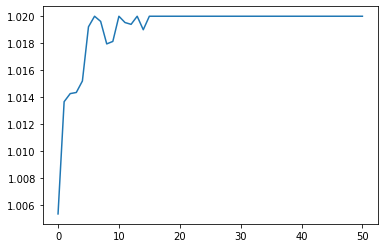

In [ ]:
n, x, y = genalg(50, 3, 50, 0.03)

## Avaliação

Para concluir com sucesso este exercício com avaliação 100%, seu algoritmo deve  gerar uma rede neural capaz de controlar o pêngulo gerando uma soma total de reforços R=1.02. Se você conseguir menos que 1.01 < R < 1.02 sua nota será reduzida para 70%, e se conseguir 0.5 < R < 1.0 sua nota será 50%. Se R < 0.5 ou se o código não executar, sua nota será nula para este exercício.